# 목차
## 1. LMS 따라하기_기본
## 2. LMS 따라하기_랭킹 업!
## 3. 프로젝트_리더보드 도전.

***
# 1. LMS 따라하기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [10]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [11]:
# 학습데이터 라벨 옮겨 놓고 제거하기.
y = data['price']

del data['price']

In [12]:
# 전체 데이터를 탐색하기 위해, 학습데이터와 테스트 데이터를 합친다.
train_len = len(data) #훈련데이터만 따로 분리할수 있게 길이를 저장하여 인덱스로 사용한다.
data = pd.concat((data, sub), axis=0)

In [13]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

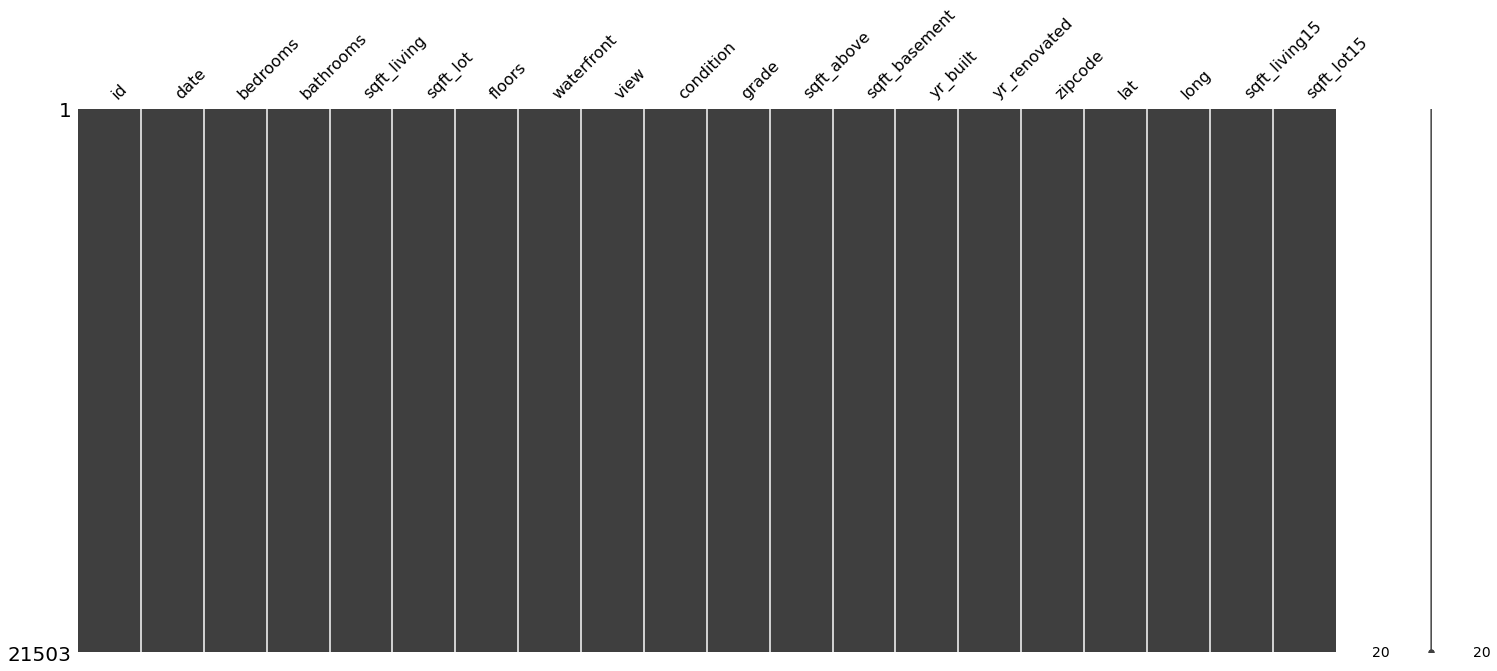

In [14]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [ ]:
loc : 라벨값 기반의 2차원 인덱싱
iloc : 순서를 나타내는 정수 기반의 2차원 인덱싱
df.loc[행 인덱싱값, 열 인덱싱값]


In [16]:
null_check = pd.isnull(data['id'])
print(null_check) # T F 의 df 가 출력된다.

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [17]:
# 2. 결측치 데이터만 뽑아 낸다.
null_data = data.loc[null_check,'id'] # 
null_data.head()

Series([], Name: id, dtype: int64)

In [18]:
# 3. 결측치인 데이터 개수를 센다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [19]:
# 4. 한번에 작성
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [20]:
# 모든 컬럼에 적용
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [21]:
sub_id = data['id'][train_len:] # 테스트데이터 아이디 뺴놓기
del data['id'] # id 지우기
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) # data 연월 만 고려, 범주형으로 바꾸기

In [23]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

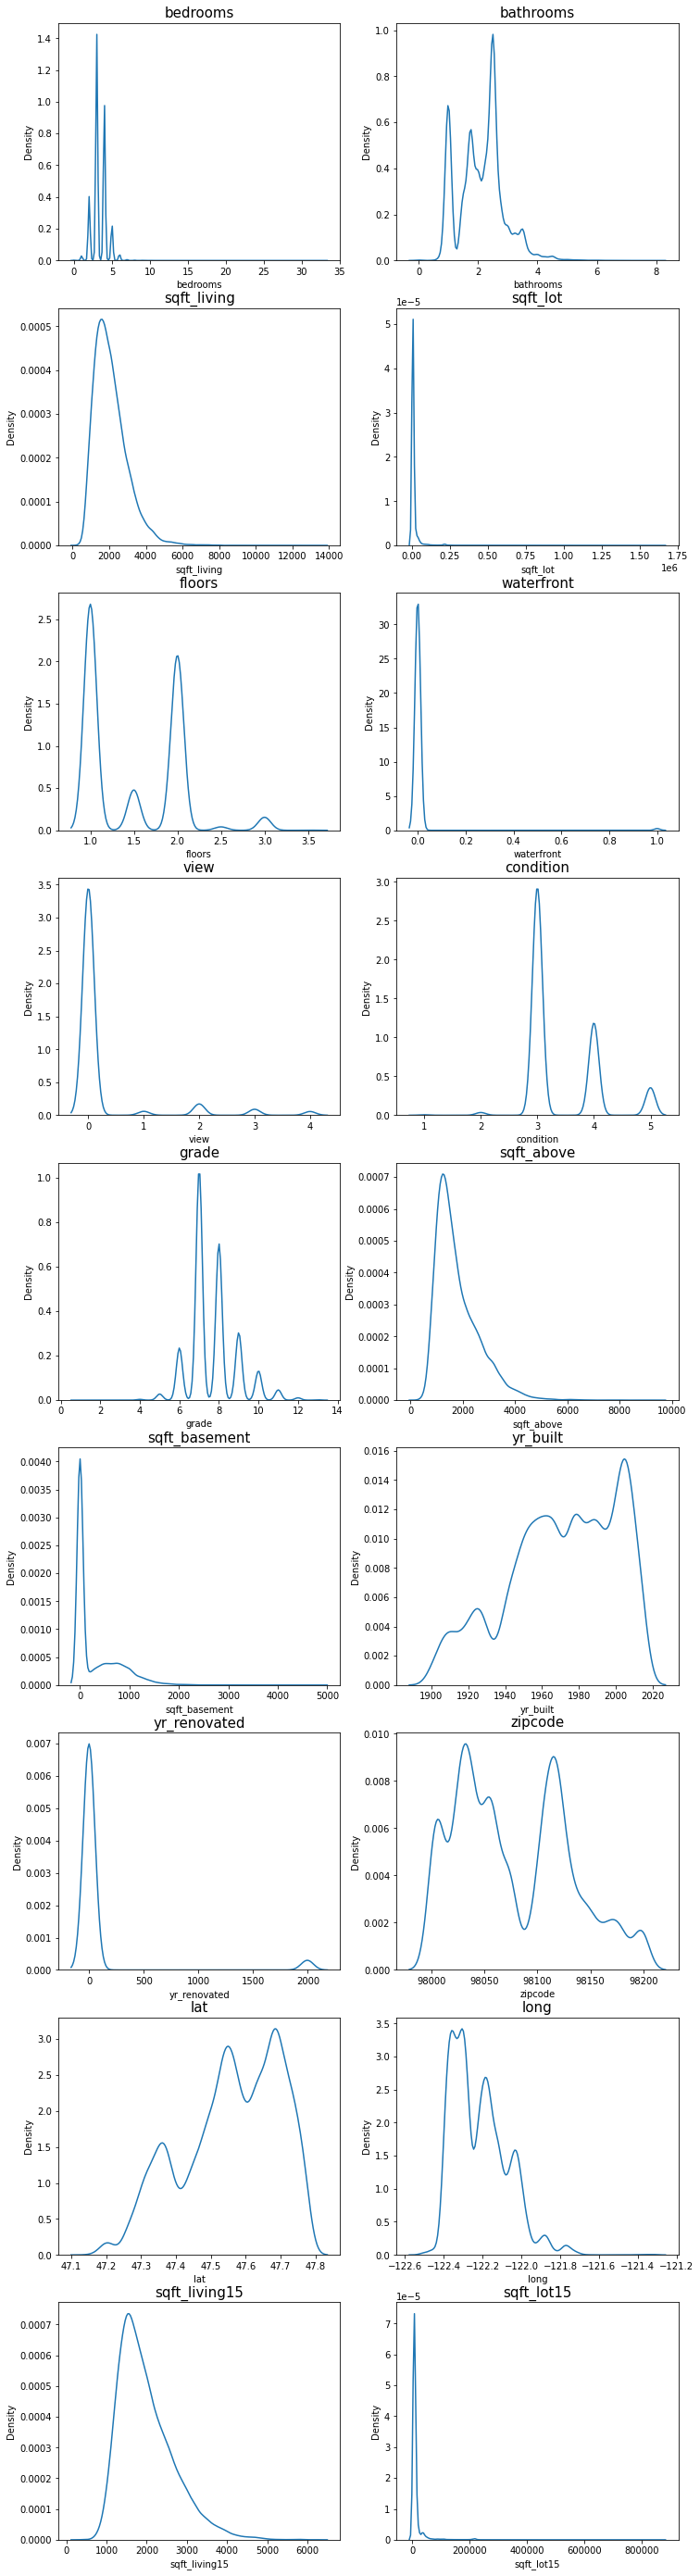

In [27]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [31]:
# 치우친 경향을 보이는 컬럼에 대해서 log scaling
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


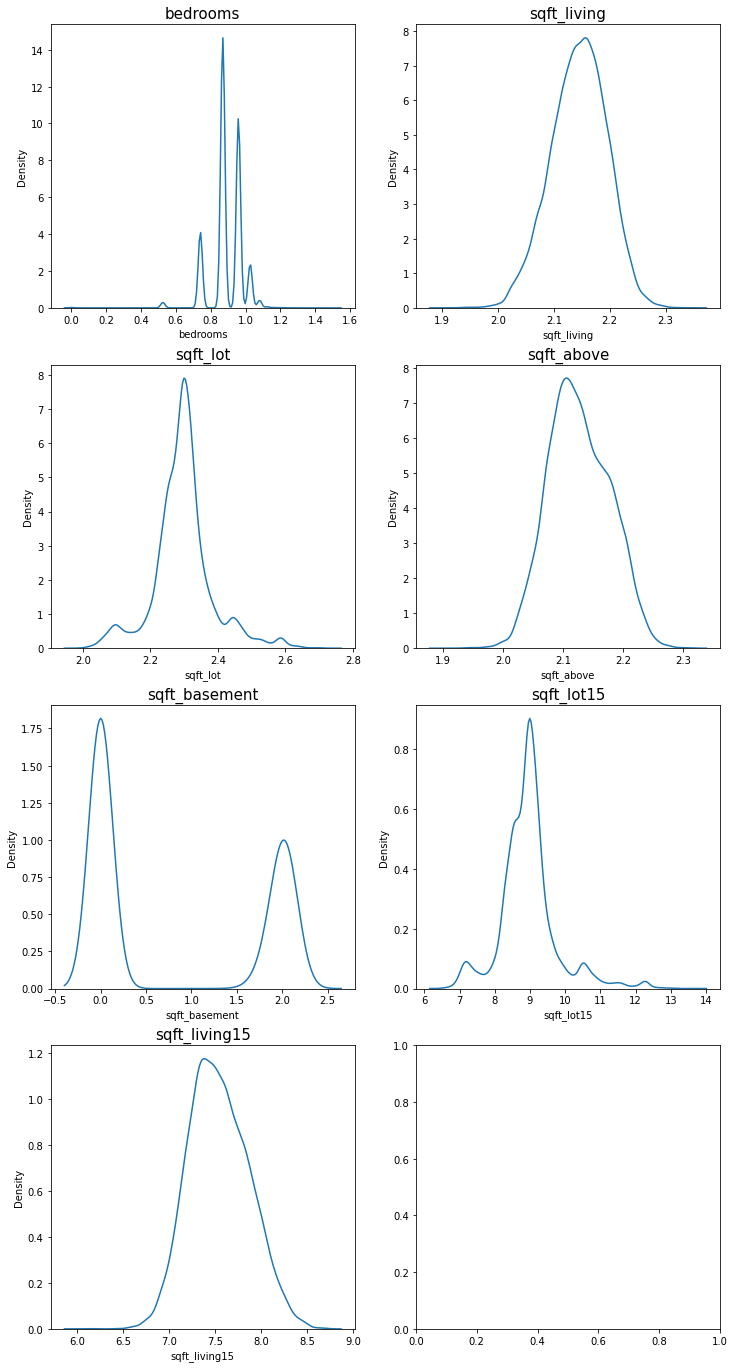

In [32]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [33]:
# 전체 데이터 필요한 데이터 처리 완료, 전체 데이터를 다시 나누자.
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [34]:
# 부스팅 계열 3가지 사용
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [35]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [36]:
get_cv_score(models) # 결정계수를 반환한다.

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [37]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : # 각 모델 학습.
        m['model'].fit(x.values, y)
    
    # 테스트데이터로 예측
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1) # 예측값 평균을반환.

In [38]:
y_pred = AveragingBlending(models, x, y, sub)

In [40]:
y_pred

array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [41]:
# 제출할 샘플 파일 확인
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
# 제출할 샘플 파일 확인
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [42]:
# id 와 price 로 제출할 df 만들어주기
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [43]:
# 제출할 파일 저장하기
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


#### 제출 결과
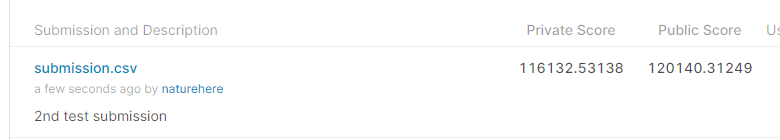

그냥 LMS 코드만 따라한 경우 private score 11만6천 정도 나온다.


# 2. LMS 따라하기_랭킹 업!

In [44]:
# 하이퍼 파라미터 튜닝으로 성능을 올려보자.

In [95]:
# 다시 데이터를 가져오자.
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [46]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [96]:
# date 를 정수형 데이터로 처리. 예측을 위한 특성으로 활용하자.
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [97]:
# 타겟 데이터 price 컬럼.
# y에  price 넣고, train에서 삭제

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [98]:
# id 컬럼 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [99]:
# 테스트 데이터도 동일하게 진행.

test['date'] = test['date'].apply(lambda i : i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [51]:
# y 확인
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

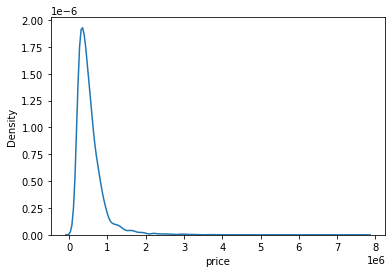

In [52]:
# 가격 분포 확인
sns.kdeplot(y)
plt.show()

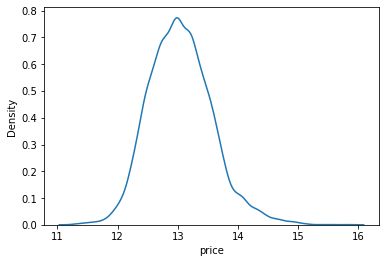

In [100]:
# 가격 분포가 왼쪽으로 치우친 형태.
# np.log1p() 로 로그 변환 하고, 모델값 예측후, np.expm1()으로 되돌리자.
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [55]:
# 모두 실수, 정수형 자료이므로 학습에 사용 가능하다.

In [58]:
# 다양한 실험을 위해 함수로 만들어 쓰자.

# RMSE 계산 함수 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

In [59]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델 을 사용하자.
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [60]:
# 데이터 분할시, random_state 지정가능, None 으로 남겨두면 데이터셋 구성이 달라짐.학습결과도 달라짐.
# 다양한 방법으로 성능이 개선 되는지 검증하려함.
# 어떤 시도가 모델성능에 긍정적인지 판단하기위해, 랜덤요소로 생기는 불확실성을 제거하자.
# 따라서 random_state 를 특정 값으로 고정한다.
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다. 

random_state=2020

#  모델 인스턴스 생성후 models 에 넣어준다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [61]:
# 각모델의 속성에 접금하여 이름을 얻는 법.
gboost.__class__.__name__

'GradientBoostingRegressor'

In [62]:
# 이름으로 접근하여 for문에서 모델 별 학습 및 예측
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [64]:
# 점수 함수

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [65]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [67]:
# 하이퍼 파라미터 튜닝
#그리드 탐색하자
from sklearn.model_selection import GridSearchCV

In [ ]:
GridSearchCV에 입력되는 인자

param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
scoring : 모델의 성능을 평가할 지표
cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [68]:
#xgboost 그리드 서치 파라미터
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [69]:
# 모델 lgbm
model = LGBMRegressor(random_state=random_state)

In [70]:
# 그리드 모델 초기화
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [71]:
# 결과 확인
grid_model.cv_results_

{'mean_fit_time': array([0.15500956, 0.24077687, 0.47121534, 0.46575947]),
 'std_fit_time': array([0.04361463, 0.07408812, 0.18231991, 0.09332462]),
 'mean_score_time': array([0.0111515 , 0.01678677, 0.02936125, 0.02810545]),
 'std_score_time': array([0.00821054, 0.00811943, 0.01682038, 0.00314397]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [72]:
# 파라미터 조합은 params, 각각에 대한 테스트 점수는 mean_test_score 에 있다.
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [73]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [74]:
# df 로 확인
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [76]:
# 앞서 neg_mean_squared_error를 사용했다.
# RMSE 를 보자
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [77]:
# 앞서 log변환되었다.
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [78]:
#`RMSLE`가 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [79]:
# 그리스 서치 전체를 함수로 만들자
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [80]:
# 위 함수로 그리드 서치 하자
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [83]:
# 가장 좋은 10, 100으로 모델을 준비하고, 학습 예측하여 결과를 보자.
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction) #원래 스케일로 돌리기
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [84]:
# 제출하기위해 샘플 csv 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [85]:
# 예측값 덮기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [86]:
# csv 로 저장하기
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.9s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max

In [ ]:
## 위 과정도 함수화 하자
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
# 학습 예측 결과 저장을 함수로 한번에
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

그리드 서치한 lgbm모델 제출, private score  11만 5천점
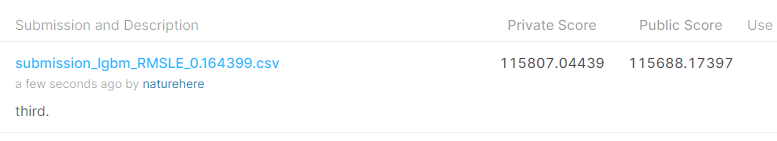

# 3. 프로젝트_리더보드 도전.

***
시도해 볼만한 것들.
- EDA 및 피처 엔지니어링.
- 하이퍼 파라미터 튜닝
- 그리드 서치, 최적의 조합 찾기
- 블렌딩 방법 활용하기.
***

In [87]:
# 앞선, 그리드 서치 과정에서, 편향된 데이터에 대한 log적용 이루어지지 않았다.
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [88]:
test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [89]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [101]:
# 전체 데이터를 탐색하기 위해, 학습데이터와 테스트 데이터를 합친다.
train_len = len(train) #훈련데이터만 따로 분리할수 있게 길이를 저장하여 인덱스로 사용한다.
data = pd.concat((train, test), axis=0)

In [102]:
# 치우친 경향을 보이는 컬럼에 대해서 log scaling
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [141]:
# 전체 데이터 필요한 데이터 처리 완료, 전체 데이터를 다시 나누자.
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)
print(y.shape)

(15035, 19)
(6468, 19)
(15035,)


In [104]:
# 이제 train, test , y 데이터
# 가격을 포함한 치우친 분포에서 log 스케일링이 모두 적용되었고, 날짜또한 사용가능하게 년월 까지 int로 변경되었다.

- XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델에 대해서
- 각각 그리드 서치를 통해 하이퍼 파라미터 서치를하자.

In [ ]:
random_state=2020

#  모델 인스턴스 생성후 models 에 넣어준다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [145]:
# 위 함수로 그리드 서치 하자
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,200,-0.029405,0.171478
4,10,100,-0.029460,0.171639
3,10,50,-0.029868,0.172824
2,1,200,-0.045150,0.212485
1,1,100,-0.055039,0.234604
0,1,50,-0.073256,0.270658


In [147]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,200,-0.026187,0.161824
4,10,100,-0.027024,0.164391
3,10,50,-0.029174,0.170804
2,1,200,-0.045198,0.212597
1,1,100,-0.055024,0.234571
0,1,50,-0.073398,0.270920


In [148]:
model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,200,-0.034928,0.186889
4,10,100,-0.035222,0.187676
3,10,50,-0.035425,0.188215
2,1,200,-0.178639,0.422657
1,1,100,-0.179128,0.423235
0,1,50,-0.179746,0.423965


In [163]:
# 블랜딩
# 부스팅 계열 3가지 사용
gboost = GradientBoostingRegressor(max_depth=10, n_estimators=200,random_state=random_state)
#xgboost = xgb.XGBRegressor(max_depth=10, n_estimators=100,random_state=random_state)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=200,random_state=random_state)
rdforest = RandomForestRegressor(max_depth=10, n_estimators=200,random_state=random_state)

# {'model':xgboost, 'name':'XGBoost'},
models = [{'model':gboost, 'name':'GradientBoosting'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model': rdforest, 'name':'RandomForest'}]

In [164]:
y_pred = AveragingBlending(models, train, y, test)

In [165]:
y_pred

array([13.08763357, 13.07206193, 14.09804637, ..., 13.0364334 ,
       12.74125215, 13.00777018])

In [166]:
prediction = np.expm1(y_pred)

In [167]:
prediction

array([ 482932.17527427,  475470.35900879, 1326488.28130163, ...,
        458828.24273484,  341549.95444995,  445863.41204628])

In [168]:
# 예측값 덮기
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.829322e+05
1,15036,4.754704e+05
2,15037,1.326488e+06
3,15038,3.021246e+05
4,15039,3.304399e+05


In [169]:
my_submission_path = join(data_dir, 'submission4.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission4.csv


submission 4th, 12만점? 

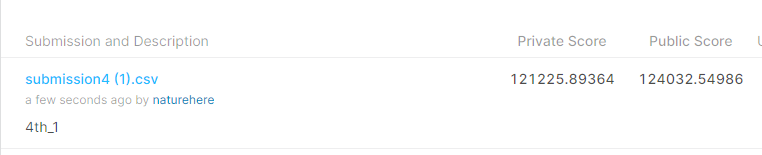

In [ ]:
# 과적합은 아닐까...n_estimators를 100으로 해보자.

In [170]:
gboost = GradientBoostingRegressor(max_depth=10, n_estimators=100,random_state=random_state)
#xgboost = xgb.XGBRegressor(max_depth=10, n_estimators=100,random_state=random_state)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=100,random_state=random_state)
rdforest = RandomForestRegressor(max_depth=10, n_estimators=100,random_state=random_state)
y_pred = AveragingBlending(models, train, y, test)

In [171]:
prediction = np.expm1(y_pred)

In [172]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.829322e+05
1,15036,4.754704e+05
2,15037,1.326488e+06
3,15038,3.021246e+05
4,15039,3.304399e+05


In [173]:
my_submission_path = join(data_dir, 'submission5.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission5.csv


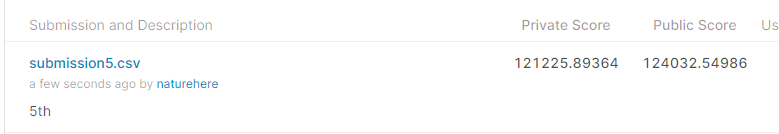


In [174]:
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=200,random_state=random_state)
lightgbm.fit(train, y)

LGBMRegressor(max_depth=10, n_estimators=200, random_state=2020)

In [177]:
y_pred = lightgbm.predict(test)
prediction = np.expm1(y_pred)
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.024975e+05
1,15036,4.718326e+05
2,15037,1.359938e+06
3,15038,3.050260e+05
4,15039,3.346215e+05


In [178]:
my_submission_path = join(data_dir, 'submission6.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission6.csv


앞선 그리드서치에서 성능이 가장 좋았던, lgbm 모델만 사용해보았다.
11만2천
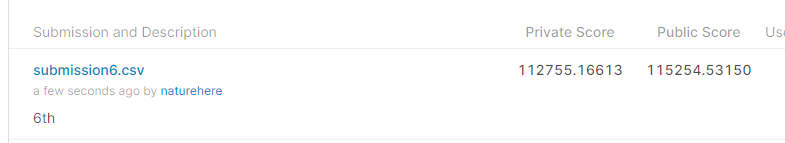

In [179]:
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=300,random_state=random_state)
lightgbm.fit(train, y)

LGBMRegressor(max_depth=10, n_estimators=300, random_state=2020)

In [180]:
y_pred = lightgbm.predict(test)
prediction = np.expm1(y_pred)
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.175211e+05
1,15036,4.769533e+05
2,15037,1.326717e+06
3,15038,3.044025e+05
4,15039,3.342625e+05


In [181]:
my_submission_path = join(data_dir, 'submission7.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission7.csv


앞선 그리드서치에서 성능이 가장 좋았던, lgbm 모델만 사용해보았다. 11만
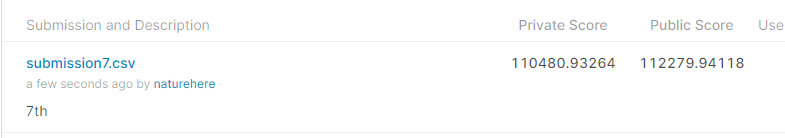

In [182]:
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=400,random_state=random_state)
lightgbm.fit(train, y)
y_pred = lightgbm.predict(test)
prediction = np.expm1(y_pred)
submission['price'] = prediction
submission.head()
my_submission_path = join(data_dir, 'submission8.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission8.csv


앞선 그리드서치에서 성능이 가장 좋았던, lgbm 모델만 사용해보았다. 11만
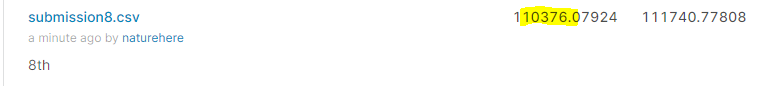

In [183]:
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=600,random_state=random_state)
lightgbm.fit(train, y)
y_pred = lightgbm.predict(test)
prediction = np.expm1(y_pred)
submission['price'] = prediction
submission.head()
my_submission_path = join(data_dir, 'submission9.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission9.csv


앞선 그리드서치에서 성능이 가장 좋았던, lgbm 모델만 사용해보았다. 10만 9천
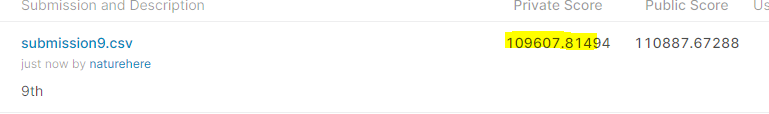

In [184]:
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=800,random_state=random_state)
lightgbm.fit(train, y)
y_pred = lightgbm.predict(test)
prediction = np.expm1(y_pred)
submission['price'] = prediction
submission.head()
my_submission_path = join(data_dir, 'submission10.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission10.csv


In [186]:
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=1200,random_state=random_state)
lightgbm.fit(train, y)
y_pred = lightgbm.predict(test)
prediction = np.expm1(y_pred)
submission['price'] = prediction
submission.head()
my_submission_path = join(data_dir, 'submission11.csv')
submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission11.csv


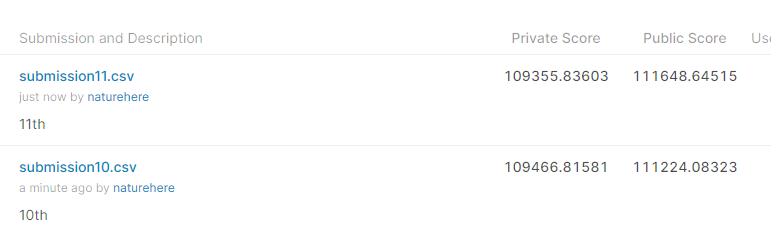

# 회고
- 어려웠던 점 : EDA와 피처엔지니어링이 아직까지 너무나도 어렵게 느껴진다. 많은 토이데이터를 통해 반복연습과 적절한 상황에 적절한 방법을 사용하는 것을 익혀야할 필요성을 느낀다.
- 알아낸 점 : 세가지 모델에 대해 그리드 서치하고, 각모델에서 가장좋은 점수를 받은 파라미터로 블렌딩 하였다. 그러나 스코어는 오히려 증가하여 좋은 성능을 보여주지 않았다. 블렌딩이 능사는 아니라고 생각한다.그래서 가장 성능이 잘나온 lgbm모델의  n_estimators 파라미터만 증가시켜가며 테스트 해보았다. 200, 300, 400, 600, 으로 증가하며 스코어를 보았는데 점점 스코어가 좋아져서 최종 1만 9천을 얻었다. 그리드 서치 단계에서 max_depth는 10과 20 모두 시도 했는데 20에서 성능향상을 보여주지 않아서 더 시도 하지 않았다.
- 시도한 것들 : LMS에 나온데로 편향이 큰 컴럼을 log 스케일링 하였고, 날짜데이터를 int로 학습에 사용할수 있게 했다. 3가지 모델에 대해서 그리드 서치하였고 그 결과를  평균블렌딩하였다. 개별모델로 성능이 가장 좋았던모델의  n_estimators 값을 증가하며 학습한 모델의 스코어 변화를 보았더니 점차 스코어가 좋아졌다.

- 자기 다짐 : EDA와 피처엔지니어링아 아직 많이 어렵게 느껴진다. 더많은 공부와 실습을 해야한다. 하이퍼파라미터 튜닝을 각 모델에 대한 학습과 이해가 더 필요하다. 그렇게 해서 각 파라미터가 갖은 의미와 데이터에 기반하여 튜닝과 그 해석을 낼수 있도록 노력해야겠다.